<a href="https://colab.research.google.com/github/kaleem500bc/Simple_GAN-MNIST-torch-and-tensorflow/blob/master/Mnist_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets


In [71]:
transform = torchvision.transforms.Compose([
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.5,),(0.5,))
])
dataset = torchvision.datasets.MNIST('data',train=True,download=True,transform=transform)

datasetBatch = torch.utils.data.DataLoader(dataset,32,shuffle=True)
dataiter = iter(datasetBatch)

In [74]:


class netG(nn.Module):
  def __init__(self):
    super().__init__()
    self.f = nn.Linear(100,400)
    self.c1 = nn.ConvTranspose2d(1,128,3)
    self.b1 = nn.BatchNorm2d(128)
    self.c2 = nn.ConvTranspose2d(128,256,3)
    self.b2 = nn.BatchNorm2d(256)
    self.c3 = nn.ConvTranspose2d(256,64,3)
    self.b3 = nn.BatchNorm2d(64)
    self.c5 = nn.ConvTranspose2d(64,1,3)
  def forward(self,x):
    x = F.leaky_relu(self.f(x),negative_slope=0.2)
    x = x.view(x.shape[0],1,20,20)
    x = F.leaky_relu(self.b1(self.c1(x)),negative_slope=0.2)
    x = F.leaky_relu(self.b2(self.c2(x)),negative_slope=0.2)
    x = F.leaky_relu(self.b3(self.c3(x)),negative_slope=0.2)
    x = torch.tanh(self.c5(x))
    return x

generatorM = netG()



In [75]:
noise = torch.randn(1,100)
o = generatorM(noise)
print(o.shape)

torch.Size([1, 1, 28, 28])


In [76]:
class netD(nn.Module):
  def __init__(self):
    super().__init__()
    self.c1 = nn.Conv2d(1,256,3)
    self.c2 = nn.Conv2d(256,64,3)
    self.c5 = nn.Conv2d(64,1,3)
    self.fl = nn.Flatten()
    self.f1 = nn.Linear(484,256)
    self.f2 = nn.Linear(256,128)
    self.f = nn.Linear(128,1)
    self.pool = nn.MaxPool2d(2)
  def forward(self,x):
    x = self.c1(x)
    x = F.leaky_relu(self.c2(x),negative_slope=0.2)
    # x = self.pool(x)
    x = F.leaky_relu(self.c5(x),negative_slope=0.2)
    x = self.fl(x)
    x = F.leaky_relu(self.f1(x),negative_slope=0.2)
    x = nn.Dropout(0.05)(x)
    x = F.leaky_relu(self.f2(x), negative_slope=0.2)
    x = torch.sigmoid(self.f(x))
    return x

discriminatorM = netD()

In [77]:
i, _ = dataiter.next()
o = discriminatorM(i)

In [78]:
def weight_init(layer):
  typ = type(layer)
  if typ == nn.Linear or typ == nn.Conv2d or typ == nn.ConvTranspose2d:
    nn.init.xavier_normal_(layer.weight)

discriminatorM.apply(weight_init)
generatorM.apply(weight_init)

netG(
  (f): Linear(in_features=100, out_features=400, bias=True)
  (c1): ConvTranspose2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): ConvTranspose2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (b2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
  (b3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1))
)

In [79]:
criterion = nn.BCELoss()
def totalLossD(realOutput,fakeOutput):
  alpha = (0.01*torch.rand(1))[0]
  ones = torch.empty(realOutput.shape).fill_(1-alpha+(alpha/2)).to("cuda")
  # print(ones.shape)
  zeros = torch.empty_like(fakeOutput).fill_(alpha/2).to("cuda")
  loss1 = criterion(realOutput,ones)
  loss0 = criterion(fakeOutput,zeros)
  totalLoss = loss1+loss0
  return totalLoss

def totalLossG(fakeOutput):
  ones = torch.ones_like(fakeOutput).to("cuda")
  loss = criterion(fakeOutput,ones)
  return loss

In [80]:

optD = torch.optim.Adam(discriminatorM.parameters())
optG = torch.optim.SGD(generatorM.parameters(),lr=0.001,momentum=0.1)


In [81]:
generatorM.to("cuda")
discriminatorM.to("cuda")
def training():
  epoch = 10
  plossd = 0
  plossg = 0

  for e in range(epoch):
    print("iteration: " + str(e+1))
    for img2,label in datasetBatch:
      img = (img2).to("cuda")
      r_output = discriminatorM(img)

      g_input = torch.randn(32,100).to("cuda")

      f_img = generatorM(g_input) 

      f_output = discriminatorM(f_img.detach())

      optD.zero_grad()
      dloss = totalLossD(r_output,f_output)
      dloss.backward()
      optD.step()

      optG.zero_grad()
      g2_input = torch.randn(32,100).to("cuda")
      f2_img = generatorM(g2_input)
      f2_output = discriminatorM(f2_img)
      gloss = totalLossG(f2_output)
      gloss.backward()
      optG.step()
      plossg = plossg+gloss.item()
      plossd = plossd+dloss.item()
    print("Generator: "+ str(plossg))
    print("Discriminator: "+ str(plossd))
    plossd = 0
    plossg = 0


In [82]:
training()

iteration: 1
Generator: 5575.891739528628
Discriminator: 962.9281511828303
iteration: 2
Generator: 5677.31806242466
Discriminator: 898.6331876963377
iteration: 3
Generator: 6075.148789644241
Discriminator: 764.6299295052886
iteration: 4
Generator: 6535.673730373383
Discriminator: 704.0178930088878
iteration: 5
Generator: 6714.335629463196
Discriminator: 659.9772656559944
iteration: 6
Generator: 6981.108736872673
Discriminator: 618.445713929832
iteration: 7
Generator: 7040.169944286346
Discriminator: 614.800216242671
iteration: 8
Generator: 6878.311809420586
Discriminator: 634.4761384949088
iteration: 9
Generator: 6873.324356675148
Discriminator: 626.9639543741941
iteration: 10
Generator: 6801.384039521217
Discriminator: 636.9311987608671


In [83]:
input = torch.randn(64,100).to("cuda")
img = generatorM(input)

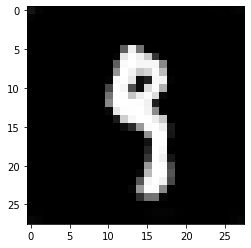

In [84]:
img = img.view(64,28,28).to("cpu")

plt.imshow(img[4].detach().numpy(),cmap='gray')
n=0

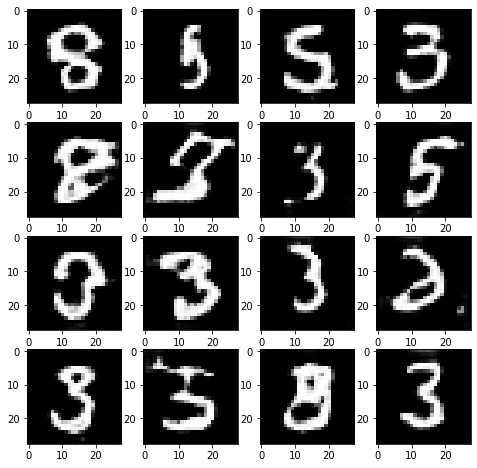

In [88]:
n = n+1
plt.figure(figsize=(8,8))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(img[n+16+i].detach().numpy(),cmap="gray")
plt.show()